<a href="https://colab.research.google.com/github/nimamt/machine_learning/blob/master/pytorch/reinforcement/NormalizedAdvantageFunction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%%bash

apt-get install swig

git clone https://github.com/pybox2d/pybox2d
cd pybox2d
python setup.py build
python setup.py install

apt-get install -y xvfb

pip install \
    gym==0.21 \
    gym[box2d]==0.21 \
    pytorch-lightning==1.6.0 \
    pyglet==1.5.27 \
    pyvirtualdisplay


Reading package lists...
Building dependency tree...
Reading state information...
The following additional packages will be installed:
  swig4.0
Suggested packages:
  swig-doc swig-examples swig4.0-examples swig4.0-doc
The following NEW packages will be installed:
  swig swig4.0
0 upgraded, 2 newly installed, 0 to remove and 19 not upgraded.
Need to get 1,086 kB of archives.
After this operation, 5,413 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu focal/universe amd64 swig4.0 amd64 4.0.1-5build1 [1,081 kB]
Get:2 http://archive.ubuntu.com/ubuntu focal/universe amd64 swig all 4.0.1-5build1 [5,528 B]
Fetched 1,086 kB in 1s (1,660 kB/s)
Selecting previously unselected package swig4.0.
(Reading database ... 128208 files and directories currently installed.)
Preparing to unpack .../swig4.0_4.0.1-5build1_amd64.deb ...
Unpacking swig4.0 (4.0.1-5build1) ...
Selecting previously unselected package swig.
Preparing to unpack .../swig_4.0.1-5build1_all.deb ...
Unp

Cloning into 'pybox2d'...
Box2D/Common/b2Math.h:67: Warning 302: Identifier 'b2Vec2' redefined by %extend (ignored),
Box2D/Box2D_math.i:47: Warning 302: %extend definition of 'b2Vec2'.
Box2D/Common/b2Math.h:158: Warning 302: Identifier 'b2Vec3' redefined by %extend (ignored),
Box2D/Box2D_math.i:168: Warning 302: %extend definition of 'b2Vec3'.
Box2D/Common/b2Math.h:197: Warning 302: Identifier 'b2Mat22' redefined by %extend (ignored),
Box2D/Box2D_math.i:301: Warning 302: %extend definition of 'b2Mat22'.
Box2D/Common/b2Math.h:271: Warning 302: Identifier 'b2Mat33' redefined by %extend (ignored),
Box2D/Box2D_math.i:372: Warning 302: %extend definition of 'b2Mat33'.
Box2D/Collision/b2DynamicTree.h:44: Warning 312: Nested union not currently supported (ignored).
Box2D/Common/b2Settings.h:144: Warning 506: Can't wrap varargs with keyword arguments enabled
Box2D/Common/b2Math.h:91: Warning 509: Overloaded method b2Vec2::operator ()(int32) effectively ignored,
Box2D/Common/b2Math.h:85: Warnin

In [2]:
from pyvirtualdisplay import Display
Display(visible=False, size=(1400, 900)).start()

In [3]:
import copy
import gym
import random
import torch
import random

import numpy as np
import torch.nn.functional as F

from collections import deque, namedtuple
from IPython.display import HTML
from base64 import b64encode

from torch import nn
from torch.utils.data import DataLoader
from torch.utils.data.dataset import IterableDataset
from torch.optim import AdamW

from pytorch_lightning import LightningModule, Trainer

from gym.wrappers import RecordVideo, RecordEpisodeStatistics


device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
num_gpus = torch.cuda.device_count()

In [4]:
class RLDataset(IterableDataset):

  def __init__(self, buffer, sample_size=200):
    self.buffer = buffer
    self.sample_size = sample_size

  def __iter__(self):
    for experience in self.buffer.sample(self.sample_size):
      yield experience

In [5]:
def display_video(episode=0):
  video_file = open(f'/content/videos/rl-video-episode-{episode}.mp4', "r+b").read()
  video_url = f"data:video/mp4;base64,{b64encode(video_file).decode()}"
  return HTML(f"")

In [6]:
class ReplayBuffer: 

  def __init__(self, capacity):
    self.buffer = deque(maxlen=capacity) # Will automatically delete old entries
    # to make room for new ones

  def __len__(self):
    return len(self.buffer)

  def append(self, experience):
    self.buffer.append(experience)

  def sample(self, batch_size):
    return random.sample(self.buffer, batch_size)

In [7]:
class NafDQN(nn.Module):

  def __init__(self, hidden_size, obs_size, action_dims, max_action):
    super().__init__()
    self.action_dims = action_dims
    self.max_action = torch.from_numpy(max_action).to(device)
    self.net = nn.Sequential(
        nn.Linear(obs_size, hidden_size),
        nn.ReLU(),
        nn.Linear(hidden_size, hidden_size),
        nn.ReLU()
    )
    self.linear_mu = nn.Linear(hidden_size, action_dims)
    self.linear_value = nn.Linear(hidden_size, 1)
    self.linear_matrix = nn.Linear(hidden_size, int(action_dims * (action_dims + 1) / 2))

  # Mu: compute action with highest Q-value
  @torch.no_grad()
  def mu(self, x):
    x = self.net(x)
    x = self.linear_mu(x)
    x = torch.tanh(x) * self.max_action
    return x

  # value: compute value state
  @torch.no_grad()
  def value(self, x):
    x = self.net(x)
    x = self.linear_value(x)
    return x

  # Forward: Q-value 
  def forward(self, x, a):
    x = self.net(x)
    mu = torch.tanh(self.linear_mu(x)) * self.max_action
    value = self.linear_value(x)

    # P(x)
    matrix = torch.tanh(self.linear_matrix(x))

    L = torch.zeros(x.shape[0], self.action_dims, self.action_dims).to(device)
    tril_indices = torch.tril_indices(self.action_dims, self.action_dims).to(device)
    L[:, tril_indices[0], tril_indices[1]] = matrix
    L.diagonal(dim1=1, dim2=2).exp_()
    P = L * L.transpose(2, 1)

    u_mu = (a-mu).unsqueeze(dim=1)
    u_mu_t = u_mu.transpose(1, 2)

    adv = - 1 / 2 * u_mu @ P @ u_mu_t
    adv = adv.squeeze(dim=-1)
    return value + adv

In [8]:
def noisy_policy(state, env, net, epsilon=0.0):
  state = torch.tensor([state]).to(device)
  amin = torch.from_numpy(env.action_space.low).to(device)
  amax = torch.from_numpy(env.action_space.high).to(device)
  mu = net.mu(state)
  mu = mu + torch.normal(0, epsilon, mu.size()).to(device)
  action = mu.clamp(amin, amax)
  action = action.squeeze().cpu().numpy()
  return action

In [9]:
class RepeatActionWrapper(gym.Wrapper):

  def __init__(self, env, n):
    super().__init__(env)
    self.env = env
    self.n = n

  def step(self, action):
    done = False
    total_reward = 0.0

    for _ in range(self.n):
      next_state, reward, done, info = self.env.step(action)
      total_reward += reward
      if done:
        break

    return next_state, total_reward, done, info

In [10]:
def create_environment(name):
  env = gym.make(name)
  env = RecordVideo(env, video_folder='./videos', episode_trigger=lambda x: x % 50 == 0)
  env = RepeatActionWrapper(env, n=8)
  env = RecordEpisodeStatistics(env)
  return env

In [11]:
def polyak_average(net, target_net, tau=0.01):
  for qp, tp in zip(net.parameters(), target_net.parameters()):
    tp.data.copy_(tau * qp.data + (1 - tau) * tp.data)

In [12]:
class NAFDeepQLearning(LightningModule):

  def __init__(self, env_name, policy=noisy_policy, capacity=100_000, 
              batch_size=256, lr=1e-4, hidden_size=512, gamma=0.99,
              loss_fn=F.smooth_l1_loss, optim=AdamW, eps_start=2.0,
              eps_end=0.2, eps_last_episode=1_000,
              samples_per_epoch=1_000, tau=0.01):
    super().__init__()
    self.env = create_environment(env_name)

    obs_size = self.env.observation_space.shape[0]
    action_dims = self.env.action_space.shape[0]
    max_action = self.env.action_space.high

    self.q_net = NafDQN(hidden_size, obs_size, action_dims, max_action).to(device)
    self.target_q_net = copy.deepcopy(self.q_net)
    self.policy=policy

    self.buffer = ReplayBuffer(capacity=capacity)

    self.save_hyperparameters()
    
    while len(self.buffer) < self.hparams.samples_per_epoch:
      print(f"{len(self.buffer)} samples in experience buffer. Filling...")
      self.play_episode(epsilon=self.hparams.eps_start)

  # If we dont include this, action will participate in the learning process
  @torch.no_grad() # We have a policy
  def play_episode(self, policy=None, epsilon=0.):
    state = self.env.reset()
    done = False

    while not done:
      if policy:
        action = policy(state, self.env, self.q_net, epsilon=epsilon)
      else:
        action = self.env.action_space.sample()
      next_state, reward, done, info = self.env.step(action)
      exp = (state, action, reward, done, next_state)
      self.buffer.append(exp)
      state = next_state

  def forward(self, x):
    return self.q_net.mu(x)

  def configure_optimizers(self):
    q_net_optimizer = self.hparams.optim(self.q_net.parameters(), 
                                          lr=self.hparams.lr)
    return [q_net_optimizer] # We might have multiple neural networks, hence
                              # multiple optimizers

  def train_dataloader(self):
    dataset = RLDataset(self.buffer, self.hparams.samples_per_epoch)
    dataloader = DataLoader(
        dataset=dataset,
        batch_size=self.hparams.batch_size
    )
    return dataloader

  def training_step(self, batch, batch_idx):
    states, actions, rewards, dones, next_states = batch
    rewards = rewards.unsqueeze(1)
    dones = dones.unsqueeze(1)

    action_values = self.q_net(states, actions)

    next_state_values = self.target_q_net.value(next_states)
    next_state_values[dones] = 0.0

    target = rewards + self.hparams.gamma * next_state_values

    loss = self.hparams.loss_fn(action_values, target)
    self.log("episode/Q-Loss", loss)
    return loss

  def training_epoch_end(self, training_step_outputs):

    epsilon = max(
      self.hparams.eps_end,
      self.hparams.eps_start - self.current_epoch / self.hparams.eps_last_episode
    )

    self.play_episode(policy=self.policy, epsilon=epsilon)

    polyak_average(self.q_net, self.target_q_net, tau=self.hparams.tau)

    self.log("episode/Return", self.env.return_queue[-1])

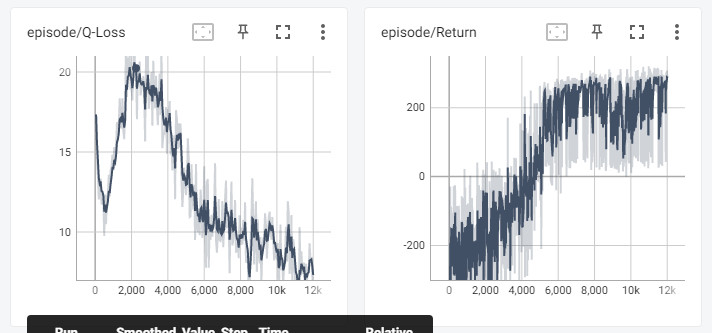

In [15]:
# !rm -r /content/lightning_logs/
# !rm -r /content/videos/
# %load_ext tensorboard
# %tensorboard --logdir /content/lightning_logs/

In [14]:
algo = NAFDeepQLearning(
    'LunarLanderContinuous-v2',
    lr=1e-3,)

trainer = Trainer(
    gpus=num_gpus,
    max_epochs=3_000,
)

trainer.fit(algo)

0 samples in experience buffer. Filling...
17 samples in experience buffer. Filling...
34 samples in experience buffer. Filling...
44 samples in experience buffer. Filling...
59 samples in experience buffer. Filling...
80 samples in experience buffer. Filling...
91 samples in experience buffer. Filling...
100 samples in experience buffer. Filling...
120 samples in experience buffer. Filling...
131 samples in experience buffer. Filling...
143 samples in experience buffer. Filling...
153 samples in experience buffer. Filling...
169 samples in experience buffer. Filling...
188 samples in experience buffer. Filling...
205 samples in experience buffer. Filling...
225 samples in experience buffer. Filling...
241 samples in experience buffer. Filling...
254 samples in experience buffer. Filling...
264 samples in experience buffer. Filling...
273 samples in experience buffer. Filling...
283 samples in experience buffer. Filling...
300 samples in experience buffer. Filling...
310 samples in exp

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True, used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.gpu:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type   | Params
----------------------------------------
0 | q_net        | NafDQN | 270 K 
1 | target_q_net | NafDQN | 270 K 
----------------------------------------
540 K     Trainable params
0         Non-trainable params
540 K     Total params
2.163     Total estimated model params size (MB)


923 samples in experience buffer. Filling...
932 samples in experience buffer. Filling...
944 samples in experience buffer. Filling...
959 samples in experience buffer. Filling...
971 samples in experience buffer. Filling...
987 samples in experience buffer. Filling...
998 samples in experience buffer. Filling...


Training: 0it [00:00, ?it/s]

<ipython-input-8-372481900c6d>:2: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:230.)
  state = torch.tensor([state]).to(device)
